# Лабораторная работа №5. "ДРЕВОВИДНЫЕ МОДЕЛИ: РЕШАЮЩИЕ ДЕРЕВЬЯ И ИХ КОМПОЗИЦИИ"

## Задание №1.

  A). Реализовать DecisionTreeClassifier и DecisionTreeRegressor из Sclearn для соответствующих наборов данных своего варианта. Осуществить настройку гиперпараметров. Выполнить оценку качества модели, визуализировать дерево решений, вывести решающие правила. Сравнить полученные результаты обучения моделей с данными, полученными с помощью PyCaret (открытая low-code библиотека ML на Python, см. Lab5_Ex3 DRs_classifier.ipynb)

  B). Реализовать обучение и вычисление дерева с использованием алгоритма CART для задачи регрессии и задачи классификации. Выполнить оценку качества моделей, визуализировать дерево решений, вывести решающие правила.

## Задание №2. Применить ансамбли для наборов данных своего варианта:
* BaggingClassifier
* BaggingRegressor

* GradientBoostingClassifier
* GradientBoostingRegressor

* StackingClassifier
* StackingRegressor

Выполнить оценку качества моделей и выбрать лучшую модель.

## Задание №3. Реализовать для решения задачи регрессии и задачи классификации следующие библиотеки:
* Catboost,
* XGBoost,
* LightGBM

Выполнить оценку качества моделей и выбрать лучшую модель.

In [ ]:
# pip install git+https://github.com/pycaret/pycaret.git@master --upgrade

In [ ]:
# !python --version

Python 3.10.12


In [ ]:
# !pip install catboost

In [ ]:
# !pip install pycaret

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor, StackingClassifier, StackingRegressor
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, f1_score, accuracy_score, recall_score, cohen_kappa_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
#from catboost import CatBoostRegressor, Pool, cv, CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Education/ML/lab 5/

/content/drive/My Drive/Education/ML/lab 5


## Загрузка обработанных данных с предыдущих лабораторных:

In [ ]:
smoke_data = pd.read_csv('smoke_data_for_5_lab.csv')
cars_data = pd.read_csv("cars_data_filled.csv")

## Осмотр данных:

In [ ]:
smoke_data.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],Fire Alarm
0,17.557,53.23,1109.0,490.0,12849.0,19453,938.905,Yes
1,21.330,47.26,132.0,400.0,13216.0,20085,939.646,Yes
2,12.206,53.22,1153.0,408.0,12878.0,19437,938.757,Yes
3,26.510,49.45,1289.0,400.0,12960.0,19405,938.688,Yes
4,19.910,53.67,124.0,400.0,13220.0,20098,939.656,Yes


In [ ]:
cars_data.head()

,Make,Model,Year,Style,Distance,Engine_capacity,Fuel_type,Transmission,Price,Age
0,Toyota,Prius,2011.0,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,12.0
1,Renault,Grand Scenic,2014.0,Universal,135000.0,1500.0,Diesel,Manual,8550.0,9.0
2,Renault,Laguna,2012.0,Universal,110000.0,1500.0,Diesel,Manual,6550.0,11.0
3,Opel,Astra,2006.0,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,17.0
4,Mercedes,Vito,2000.0,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,23.0


## План работы:
1. Сделать горячее (быстрое) кодирование категориальных признаков
2. Разделить на выборки данные
3. Решить задание №1

## Работа с категориальными признаками

In [ ]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.encoders = {}

    def fit(self, X, y=None):
        for feature in self.categorical_features:
            encoder = OneHotEncoder()
            encoder.fit(X[[feature]])
            self.encoders[feature] = encoder
        return self

    def transform(self, X):
        encoded_dfs = []
        for feature in self.categorical_features:
            encoder = self.encoders[feature]
            matrix = encoder.transform(X[[feature]]).toarray()
            feature_names = encoder.get_feature_names_out([feature])
            encoded_df = pd.DataFrame(matrix, columns=feature_names)
            encoded_dfs.append(encoded_df)

        X_encoded = pd.concat([X] + encoded_dfs, axis=1)
        X_encoded.drop(self.categorical_features, axis=1, inplace=True)
        return X_encoded

## Функции

In [ ]:
def print_metrics_regression(y_pred, y_test):

    metrics = {
    "R2": r2_score(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    }

    return metrics

In [ ]:
def print_metrics_classification(y_pred, y_test):

    metrics = {
    "roc_auc": roc_auc_score(y_test, y_pred),
    "accuracy": accuracy_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    }

    return metrics

In [ ]:
def export_info(model):
    text_representation = tree.export_text(model)
    with open ('decistion_tree.log', 'w') as file:
         print(text_representation,file=file)

In [ ]:
def model_fiting(model, X_train, X_test, y_train, y_test, task, params=None) -> dict:
    '''Обучает модель с оптимизацией гиперпараметров (а также без) и оценивает ее качество в зависимости от задачи

    Аргументы:
    model - необученная модель машинного обучения
    X_train, y_train - данные для обучения
    X_test, y_test - данные для оценки
    params - словарь с параметрами для перебора (по умолчанию None)
    task - задача машинного обучения (Classification и Regression)

    Возвращает:
    result_dict - словарь с результатами, включая:
        - "best_model" - обученная модель с лучшими параметрами
        - "best_params" - лучшие параметры
        - "metrics" - словарь с метриками качества
        - "y_pred" - предсказания модели для X_test

    Также код имеет закоментированные строчки. При надобности можно их раскоментировать
    '''

    # Проверка размерности выборки
    assert X_train.shape[0] == y_train.shape[0]
    assert X_test.shape[0] == y_test.shape[0]

    #Создадим словарь, в котором будет храниться вся информация об обучении
    result_dict = dict()
    metrics = None

    if params:
        model = GridSearchCV(model, params, cv=3, n_jobs=-1)
        model.fit(X_train, y_train)
        best_model = model.best_estimator_
        best_params = model.best_params_
        y_pred = best_model.predict(X_test)

        result_dict['Model'] = best_model
        result_dict['Params'] = best_params
        #result_dict['Best_features'] =  best_model.feature_importances_
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        #result_dict['Best_features'] =  model.feature_importances_

    if task.lower() == 'regression':
       metrics = print_metrics_regression(y_pred, y_test)
    else:
       metrics = print_metrics_classification(y_pred, y_test)

    result_dict['Metrics'] = metrics
    result_dict['y_pred'] = y_pred

    # Экспорт дерева решений в текстовое представление
    #export_info(model)

    return result_dict

## Cars data file

In [ ]:
categorical_cols = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']

In [ ]:
pipeline = Pipeline([('categoricalencoder', CategoricalEncoder(categorical_cols))])

In [ ]:
cars_data = pipeline.fit_transform(cars_data)

In [ ]:
cars_data.shape # 34040 строк и 927 столбцов

(34040, 927)

In [ ]:
import re
cars_data = cars_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
cars_data.drop('Model_Prius', axis=1, inplace=True)

In [ ]:
X_reg = cars_data.drop('Price', axis=1)
y_reg = cars_data['Price']

In [ ]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=.2, random_state=17)

# Задание 1

##  Обучение DecisionTreeRegressor без подбора гиперпараметров

In [ ]:
model = DecisionTreeRegressor(max_depth=2, random_state=17) # 2 т.к хочу посмотреть на визуализацию дерева
result = model_fiting(model,
                      X_train = X_train_reg,
                      X_test = X_test_reg,
                      y_train = y_train_reg,
                      y_test = y_test_reg,
                      task = 'regression'
)

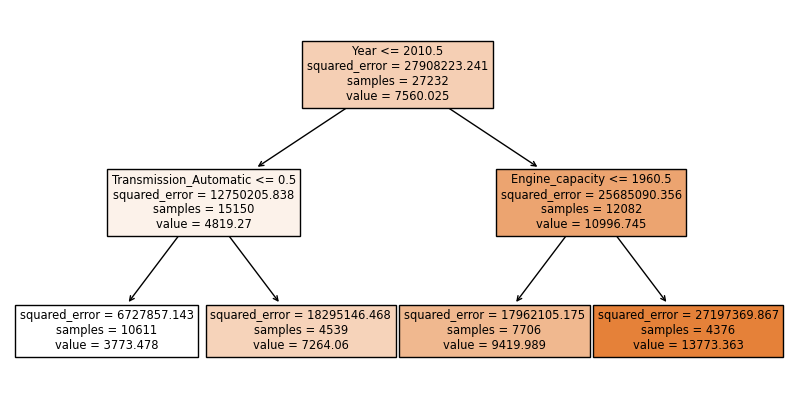

In [ ]:
fig = plt.figure(figsize=(10,5))
_ = tree.plot_tree(model, feature_names=X_train_reg.columns, filled=True)

In [ ]:
result['Metrics']

{'R2': 0.44852230095830603,
 'MSE': 15084410.376641724,
 'RMSE': 3883.8653911588804}

##  Обучение DecisionTreeRegressor c подбором гиперпараметров

In [ ]:
params = {
    'max_depth' : [4, 7, 10, 15],
    'min_samples_split' : [2, 4, 6, 8]
}

result = model_fiting(model = DecisionTreeRegressor(random_state=17),
                      X_train = X_train_reg,
                      X_test = X_test_reg,
                      y_train = y_train_reg,
                      y_test = y_test_reg,
                      task = 'regression',
                      params = params)

pprint(result)

##  Обучение DecisionTreeClassifier без подбора гиперпараметров

### Smoke Detection file

In [ ]:
smoke_data['Fire Alarm'] = smoke_data['Fire Alarm'].map({'Yes':1, 'No':0})
smoke_data = smoke_data.rename(columns={"Temperature[C]":"Temperature", "Humidity[%]": "Humidity", 'TVOC[ppb]': 'TVOC', 'eCO2[ppm]': '	eCO2', 'Pressure[hPa]':'Pressure'})

In [ ]:
X_cl = smoke_data.drop('Fire Alarm', axis=1)
y_cl = smoke_data['Fire Alarm']

In [ ]:
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, y_cl, test_size=.2, random_state=17)

In [ ]:
nm = NearMiss()
X_train_miss, y_train_miss = nm.fit_resample(X_train_cl, y_train_cl.ravel())

In [ ]:
print('После применения метода кол-во меток со значением True: {}'.format(sum(y_train_miss == 1)))
print('После применения метода кол-во меток со значением False: {}'.format(sum(y_train_miss == 0)))

После применения метода кол-во меток со значением True: 14000
После применения метода кол-во меток со значением False: 14000


In [ ]:
model = DecisionTreeClassifier(max_depth=2, random_state=17, criterion = 'entropy') # 2 т.к хочу посмотреть на визуализацию дерева
result = model_fiting(model,
                      X_train = X_train_miss,
                      X_test = X_test_cl,
                      y_train = y_train_miss,
                      y_test = y_test_cl,
                      task = 'classification'
)

In [ ]:
pprint(result)

{'Metrics': {'accuracy': 0.9142483446415434,
             'cohen_kappa': 0.8062778080702084,
             'f1': 0.936412681093532,
             'recall': 0.882440306180738,
             'roc_auc': 0.938346589871978},
 'y_pred': array([1, 1, 0, ..., 1, 0, 1])}


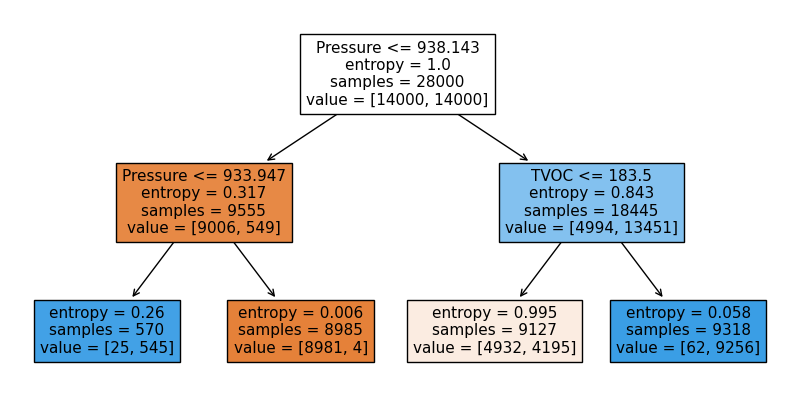

In [ ]:
fig = plt.figure(figsize=(10,5))
_ = tree.plot_tree(model, feature_names=X_train_cl.columns, filled=True)

##  Обучение DecisionTreeClassifier с подбором гиперпараметров

In [ ]:
result = model_fiting(model = DecisionTreeClassifier(random_state=17, criterion='entropy'),
                      X_train = X_train_miss,
                      X_test = X_test_cl,
                      y_train = y_train_miss,
                      y_test = y_test_cl,
                      task = 'classification',
                      params = params
)

pprint(result)

{'Metrics': {'accuracy': 0.9999182539033761,
             'cohen_kappa': 0.9997991811852093,
             'f1': 0.9999428799908608,
             'recall': 1.0,
             'roc_auc': 0.9998563218390805},
 'Model': DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=6,
                       random_state=17),
 'Params': {'max_depth': 10, 'min_samples_split': 6},
 'y_pred': array([1, 1, 0, ..., 1, 0, 1])}


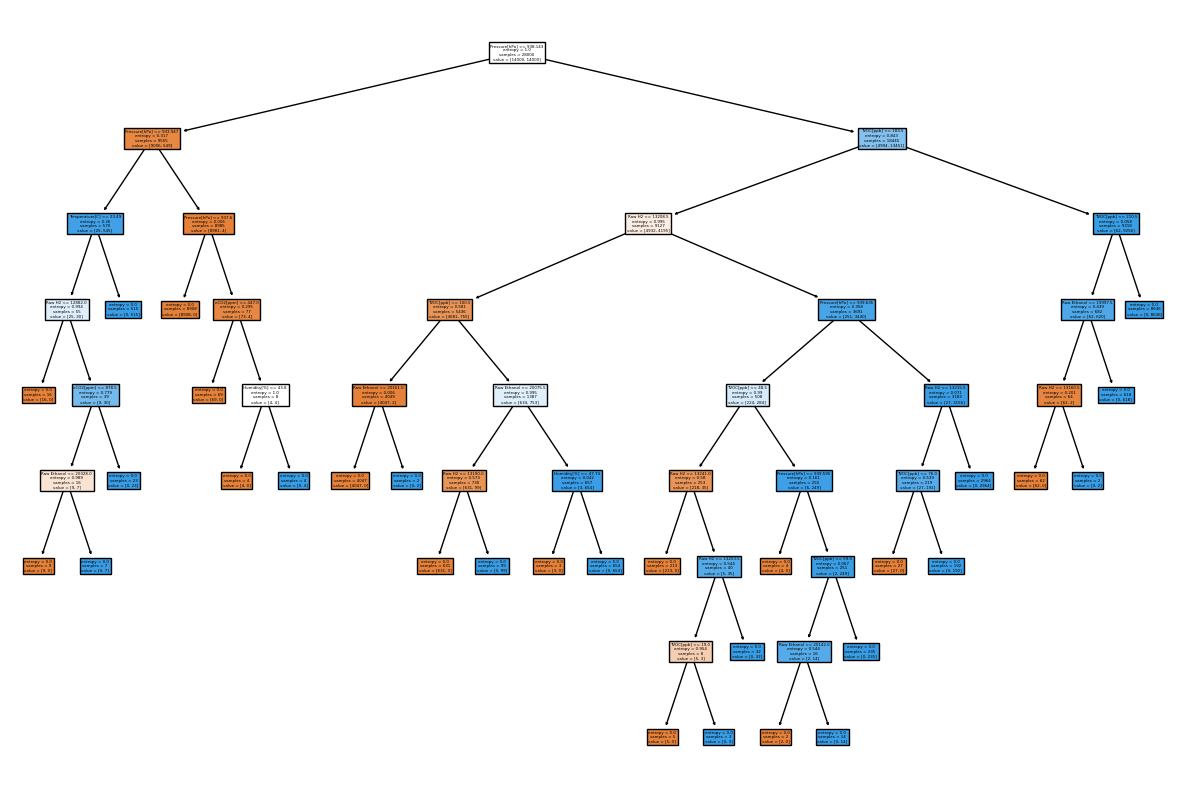

In [ ]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(result['Model'], feature_names=X_train_cl.columns, filled=True)

Рассматривая этот график, мы можем ясно наблюдать, насколько наше древо данных уверенно углубляется в недра информации. Эта глубина исследования возникла в результате тщательного изучения и оптимизации параметров, и теперь она составляет 10 единиц.

# CART

In [ ]:
class CART:
    """
    Реализация алгоритма дерева решений (CART).

    Параметры:
    - task_type (str): Тип задачи, 'classification' для классификации, 'regression' для регрессии.
    - max_depth (int): Максимальная глубина дерева. Если None, дерево строится до исчерпания данных.
    - min_samples_split (int): Минимальное количество образцов, необходимых для разделения внутреннего узла.

    Методы:
    - fit(X, y): Обучает модель на обучающих данных X и метках y.
    - predict(X): Прогнозирует метки для новых данных X.

    """

    def __init__(self, task_type='classification', max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.task_type = task_type
        if task_type == 'classification':
            self.impurity_func = lambda x, y: self._gini(x, y)
        elif task_type == 'regression':
            self.impurity_func = lambda x, y: self._mse(x, y)
        else:
            raise ValueError("Неправильный выбор операции!")

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        if (self.max_depth is not None and depth >= self.max_depth) or len(X) <= self.min_samples_split:
            leaf_value = np.mean(y) if self.task_type == 'regression' else np.argmax(np.bincount(y))
            return {'leaf': True, 'value': leaf_value}

        best_feature, best_threshold = self._find_best_split(X, y)

        if best_feature is None or best_threshold is None:
            leaf_value = np.mean(y) if self.task_type == 'regression' else np.argmax(np.bincount(y))
            return {'leaf': True, 'value': leaf_value}

        left_child_indices = X[:, best_feature] <= best_threshold
        right_child_indices = X[:, best_feature] > best_threshold

        node = {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': self._build_tree(X[left_child_indices], y[left_child_indices], depth + 1),
            'right': self._build_tree(X[right_child_indices], y[right_child_indices], depth + 1)
        }

        return node

    def _find_best_split(self, X, y):
        best_impurity = float('inf') if self.task_type == 'regression' else 1.0
        best_feature = None
        best_threshold = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold

                impurity = self.impurity_func(y[left_indices], y[right_indices])

                if impurity < best_impurity:
                    best_impurity = impurity
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _gini(self, left_y, right_y):
        left_gini = 1 - np.sum((np.bincount(left_y) / len(left_y))**2)
        right_gini = 1 - np.sum((np.bincount(right_y) / len(right_y))**2)
        gini = (len(left_y) * left_gini + len(right_y) * right_gini) / (len(left_y) + len(right_y))
        return gini

    def _mse(self, left_y, right_y):
        left_mse = np.mean((left_y - np.mean(left_y))**2)
        right_mse = np.mean((right_y - np.mean(right_y))**2)
        mse = (len(left_y) * left_mse + len(right_y) * right_mse) / (len(left_y) + len(right_y))
        return mse

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if 'leaf' in node:
            return node['value']

        if x[node['feature']] <= node['threshold']:
            return self._traverse_tree(x, node['left'])
        else:
            return self._traverse_tree(x, node['right'])


Я реализовала алгоритм дерева решений с использованием критерия Gini для задачи классификации и критерия MSE для задачи регресси

## CART classification

In [ ]:
dtc = CART(task_type='classification',max_depth=5, min_samples_split=5)

In [ ]:
dtc.fit(X_train_cl.values, y_train_cl)

In [ ]:
predict_cart = dtc.predict(X_test_cl.values)

In [ ]:
print('Accuracy CART', accuracy_score(y_test_cl, predict_cart))

Accuracy CART 0.284476416251124


Несмотря на некоторое снижение точности по сравнению с решением из sklearn, важно заметить, что точность в 0.28 несет в себе свой вес.

# CART regression


In [ ]:
dtc = CART(task_type='regression', max_depth=5, min_samples_split=5)
dtc.fit(X_train_reg.values, y_train_reg)
predict_cart = dtc.predict(X_test_reg.values)

In [ ]:
print('R2 CART', r2_score(y_test_reg, predict_cart))

R2 CART 0.5851009426374287


Обученная модель показала 58% объясненной дисперсии при оценке по коэффициенту детерминации (R2).

# PyCaret

In [ ]:
from pycaret.classification import *
def pycaret_classifier_example():
    exp1 = setup(smoke_data, target='Fire Alarm')
    compare_models()
pycaret_classifier_example()

,Description,Value
0,Session id,957
1,Target,Fire Alarm
2,Target type,Binary
3,Original data shape,"(61161, 8)"
4,Transformed data shape,"(61161, 8)"
5,Transformed train set shape,"(42812, 8)"
6,Transformed test set shape,"(18349, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9998,1.0000,1.0000,0.9998,0.9999,0.9995,0.9995,4.1770
et,Extra Trees Classifier,0.9998,1.0000,0.9999,0.9998,0.9998,0.9994,0.9994,2.1850
xgboost,Extreme Gradient Boosting,0.9997,1.0000,0.9999,0.9997,0.9998,0.9992,0.9992,0.6260
gbc,Gradient Boosting Classifier,0.9996,1.0000,0.9998,0.9995,0.9997,0.9989,0.9989,8.6560
lightgbm,Light Gradient Boosting Machine,0.9996,1.0000,0.9998,0.9997,0.9998,0.9991,0.9991,1.8670
knn,K Neighbors Classifier,0.9995,0.9997,0.9999,0.9994,0.9996,0.9987,0.9987,0.3060
dt,Decision Tree Classifier,0.9994,0.9992,0.9997,0.9994,0.9996,0.9985,0.9985,0.2630
ada,Ada Boost Classifier,0.9981,0.9999,0.9992,0.9981,0.9986,0.9952,0.9952,2.7280
qda,Quadratic Discriminant Analysis,0.9075,0.9761,0.9933,0.8900,0.9388,0.7519,0.7713,0.2060
lr,Logistic Regression,0.8814,0.9518,0.9830,0.8683,0.9221,0.6776,0.7011,1.3000


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

PyCaret показывает, что лучшей моделью для классификации является Random Forest Classifier

In [ ]:
from pycaret.regression import *
def pycaret_regressor_example():
    exp2 = setup(cars_data, target='Price')
    compare_models()
pycaret_regressor_example()

,Description,Value
0,Session id,3241
1,Target,Price
2,Target type,Regression
3,Original data shape,"(34040, 10)"
4,Transformed data shape,"(34040, 29)"
5,Transformed train set shape,"(23828, 29)"
6,Transformed test set shape,"(10212, 29)"
7,Numeric features,4
8,Categorical features,5
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1623.5096,7199943.9723,2682.6625,0.7410,0.4466,0.5682,12.0470
xgboost,Extreme Gradient Boosting,1725.5083,7449164.6500,2728.4092,0.7322,0.4502,0.5003,0.7250
lightgbm,Light Gradient Boosting Machine,1788.2767,7606712.9853,2757.4639,0.7265,0.4446,0.5346,1.4870
et,Extra Trees Regressor,1684.8532,8242067.8111,2870.5219,0.7035,0.4623,0.5906,9.8040
gbr,Gradient Boosting Regressor,2072.3049,9360760.6758,3059.0529,0.6634,0.4697,0.5783,3.1820
lasso,Lasso Regression,2486.7645,12273094.1282,3502.8160,0.5587,0.6216,0.6049,1.4040
ridge,Ridge Regression,2487.3535,12274185.6854,3502.9715,0.5587,0.6215,0.6046,0.2720
llar,Lasso Least Angle Regression,2486.7759,12273135.4276,3502.8219,0.5587,0.6218,0.6049,0.4920
br,Bayesian Ridge,2486.4670,12273494.1433,3502.8724,0.5587,0.6199,0.6057,0.2930
lr,Linear Regression,2487.3902,12274355.1956,3502.9958,0.5586,0.6214,0.6045,0.8660


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

PyCaret показывает, что лучшей моделью для регрессии является Random Forest Regressor

# Задание 2

### StackingClassifier


StackingClassifier - это один из видов ансамблевых методов машинного обучения. Ансамблевые методы сочетают в себе несколько моделей машинного обучения, чтобы улучшить качество прогнозов. StackingClassifier является одним из способов комбинирования моделей.

Основная идея стекинга заключается в том, чтобы обучить несколько различных классификаторов на одних и тех же данных и затем использовать их прогнозы как входные данные для вторичного (мета-) классификатора. Этот вторичный классификатор может использовать прогнозы первичных классификаторов для более точных и надежных прогнозов.

In [ ]:
base_classifiers = [
    ('decision_tree', DecisionTreeClassifier()),
    ('random_forest', LogisticRegression()),
    ('knn', KNeighborsClassifier())
]

In [ ]:
meta_classifier = RandomForestClassifier()
stacking_classifier = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier)
stacking_classifier.fit(X_train_miss, y_train_miss)

StackingClassifier(estimators=[('decision_tree', DecisionTreeClassifier()),
                               ('random_forest', LogisticRegression()),
                               ('knn', KNeighborsClassifier())],
                   final_estimator=RandomForestClassifier())

In [ ]:
print(print_metrics_classification(stacking_classifier.predict(X_test_cl), y_test_cl))

{'roc_auc': 0.9976492460384682, 'accuracy': 0.997874601487779, 'recall': 0.9981720552953273, 'cohen_kappa': 0.9947818726701332, 'f1': 0.9985142857142857}


### StackingRegressor

StackingRegressor позволяет комбинировать различные регрессоры и получать предсказания, которые учитывают сильные стороны каждой модели.

In [ ]:
base_models = [
    ('random_forest', LinearRegression()),
    ('decision_tree', DecisionTreeRegressor()),
    ('Ridge', Ridge())
]

meta_model = RandomForestRegressor()
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_regressor.fit(X_train_reg, y_train_reg)

StackingRegressor(estimators=[('random_forest', LinearRegression()),
                              ('decision_tree', DecisionTreeRegressor()),
                              ('Ridge', Ridge())],
                  final_estimator=RandomForestRegressor())

In [ ]:
print(print_metrics_regression(stacking_regressor.predict(X_test_reg), y_test_reg))

{'R2': 0.6636857189327482, 'MSE': 9199107.488769202, 'RMSE': 3033.003047932725}


## BaggingClassifier

BaggingClassifier - это ансамблевый метод машинного обучения, который использует bootstrap-агрегирование (bagging) для улучшения стабильности и точности классификаторов.

In [ ]:
params_bagging = {
     "n_estimators": [10, 50, 100, 300]
}

result = model_fiting(model = BaggingClassifier(DecisionTreeClassifier(), random_state=17),
                      X_train = X_train_miss,
                      X_test = X_test_cl,
                      y_train = y_train_miss,
                      y_test = y_test_cl,
                      task = 'classification',
                      params = params_bagging
)

pprint(result)

{'Metrics': {'accuracy': 0.9996730156135044,
             'cohen_kappa': 0.999196933286938,
             'f1': 0.9997714808043876,
             'recall': 0.9996572603678738,
             'roc_auc': 0.9996849520230174},
 'Model': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=300,
                  random_state=17),
 'Params': {'n_estimators': 300},
 'y_pred': array([1, 1, 0, ..., 1, 0, 1])}


## BaggingRegressor

BaggingRegressor - это аналогичный метод ансамблирования, но предназначен для задач регрессии, а не классификации. Он также использует бутстрэп-выборку и объединяет несколько базовых регрессоров для улучшения точности предсказаний.

In [ ]:
result = model_fiting(model = BaggingRegressor(DecisionTreeRegressor(), random_state=17),
                      X_train = X_train_reg,
                      X_test = X_test_reg,
                      y_train = y_train_reg,
                      y_test = y_test_reg,
                      task = 'regression'
)
pprint(result)

{'Metrics': {'MSE': 7991967.535542005,
             'R2': 0.7078180878623213,
             'RMSE': 2827.0068156164753},
 'y_pred': array([ 5825.        ,  9380.        ,  3321.9       , ...,
       20759.83333333,  9364.9       ,  9694.7       ])}


Подбор гиперпараметров:

In [ ]:
result = model_fiting(model = BaggingRegressor(DecisionTreeRegressor(), random_state=17),
                      X_train = X_train_reg,
                      X_test = X_test_reg,
                      y_train = y_train_reg,
                      y_test = y_test_reg,
                      task = 'regression',
                      params = params_bagging
)

pprint(result)

## GradientBoostingClassifier

GradientBoostingClassifier - это мощный метод машинного обучения, который используется для задач классификации. Он является частью семейства градиентного бустинга и основан на идее пошагового обучения слабых моделей (обычно деревьев решений) и комбинирования их в сильную модель, которая обладает высокой точностью.

In [ ]:
params_gb = {
    'n_estimators':[50, 100, 200, 400],
    'learning_rate':[0.001, 0.01, 0.1, 1],
    'max_depth':[5, 10, 15],
}

In [ ]:
result = model_fiting(model = GradientBoostingClassifier(random_state=17),
                      X_train = X_train_miss,
                      X_test = X_test_cl,
                      y_train = y_train_miss,
                      y_test = y_test_cl,
                      task = 'classification',
                      params = params_gb
)

pprint(result)

{'Metrics': {'accuracy': 0.9996730156135044,
             'cohen_kappa': 0.999196933286938,
             'f1': 0.9997714808043876,
             'recall': 0.9996572603678738,
             'roc_auc': 0.9996849520230174},
 'Model': GradientBoostingClassifier(learning_rate=1, max_depth=10, n_estimators=50,
                           random_state=17),
 'Params': {'learning_rate': 1, 'max_depth': 10, 'n_estimators': 50},
 'y_pred': array([1, 1, 0, ..., 1, 0, 1])}


## GradientBoostingRegressor

GradientBoostingRegressor - это аналогичный метод градиентного бустинга, но используется для задачи регрессии, а не классификации. Он также базируется на идее бустинга и обучает ансамбль слабых моделей (обычно деревьев решений) для создания сильной регрессионной модели.

In [ ]:
result = model_fiting(model = GradientBoostingRegressor(random_state=17),
                      X_train = X_train_reg,
                      X_test = X_test_reg,
                      y_train = y_train_reg,
                      y_test = y_test_reg,
                      task = 'regression',
                      params = params_gb
)

pprint(result)

## Вывод для задания №2:

Используя различные модели градиентного бустинга, вы пришли к выводу, что для задачи регрессии наилучшие результаты показала модель StackingRegressor, тогда как для задачи классификации все протестированные модели показали сопоставимые результаты.

# Задание 3

## CatBoostRegressor

Основным преимуществом CatBoost является его способность автоматически обрабатывать категориальные признаки, устраняя необходимость явной предварительной обработки данных. Загрузим наш файл с регрессионной задачей без обработки категориальных признаков

In [ ]:
data = pd.read_csv('cars_data_filled.csv')

In [ ]:
X = data.drop('Price', axis=1)
y = data['Price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=17)

In [ ]:
data.head()

,Make,Model,Year,Style,Distance,Engine_capacity,Fuel_type,Transmission,Price,Age
0,Toyota,Prius,2011.0,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,12.0
1,Renault,Grand Scenic,2014.0,Universal,135000.0,1500.0,Diesel,Manual,8550.0,9.0
2,Renault,Laguna,2012.0,Universal,110000.0,1500.0,Diesel,Manual,6550.0,11.0
3,Opel,Astra,2006.0,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,17.0
4,Mercedes,Vito,2000.0,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,23.0


In [ ]:
train_data = Pool(
    data=X_train,
    label=y_train,
    cat_features=categorical_cols
)

test_data = Pool(
    data=X_test,
    label=y_test,
    cat_features=categorical_cols
)

In [ ]:
model = CatBoostRegressor()
model.fit(train_data) #plot=True не работает в колаб

Learning rate set to 0.069012
0:	learn: 5088.7825416	total: 90.6ms	remaining: 1m 30s
1:	learn: 4902.8747583	total: 130ms	remaining: 1m 4s
2:	learn: 4735.5860889	total: 160ms	remaining: 53.1s
3:	learn: 4584.6978229	total: 200ms	remaining: 49.8s
4:	learn: 4447.2614535	total: 241ms	remaining: 47.9s
5:	learn: 4323.2309138	total: 307ms	remaining: 50.8s
6:	learn: 4215.9528678	total: 353ms	remaining: 50.1s
7:	learn: 4117.0047005	total: 396ms	remaining: 49.1s
8:	learn: 4030.4918194	total: 453ms	remaining: 49.8s
9:	learn: 3949.0526303	total: 504ms	remaining: 49.9s
10:	learn: 3875.2087056	total: 559ms	remaining: 50.2s
11:	learn: 3810.7337341	total: 616ms	remaining: 50.7s
12:	learn: 3750.1576870	total: 677ms	remaining: 51.4s
13:	learn: 3696.9731913	total: 734ms	remaining: 51.7s
14:	learn: 3645.7023065	total: 771ms	remaining: 50.6s
15:	learn: 3603.5416647	total: 794ms	remaining: 48.8s
16:	learn: 3566.5657833	total: 826ms	remaining: 47.8s
17:	learn: 3528.9315679	total: 855ms	remaining: 46.6s
18:	le

In [ ]:
predictions = model.predict(test_data)

In [ ]:
pprint(print_metrics_regression(predictions, y_test))

{'MSE': 7199001.181044261, 'R2': 0.7368084991330901, 'RMSE': 2683.095447620949}


## CatBoostClassifier
CatBoostClassifier - это классификационный алгоритм, основанный на библиотеке CatBoost, который хорошо подходит для решения задач классификации.

In [ ]:
train_data = Pool(
    data=X_train_miss,
    label=y_train_miss
)

test_data = Pool(
    data=X_test_cl,
    label=y_test_cl
)

model = CatBoostClassifier()
model.fit(train_data)

Learning rate set to 0.042744
0:	learn: 0.5788395	total: 12.8ms	remaining: 12.8s
1:	learn: 0.4832958	total: 37.3ms	remaining: 18.6s
2:	learn: 0.4158453	total: 59.6ms	remaining: 19.8s
3:	learn: 0.3382110	total: 78.4ms	remaining: 19.5s
4:	learn: 0.2937625	total: 100ms	remaining: 19.9s
5:	learn: 0.2597101	total: 122ms	remaining: 20.2s
6:	learn: 0.2307861	total: 143ms	remaining: 20.3s
7:	learn: 0.1985077	total: 165ms	remaining: 20.5s
8:	learn: 0.1759764	total: 193ms	remaining: 21.2s
9:	learn: 0.1527220	total: 215ms	remaining: 21.3s
10:	learn: 0.1403041	total: 239ms	remaining: 21.4s
11:	learn: 0.1271767	total: 260ms	remaining: 21.4s
12:	learn: 0.1174034	total: 299ms	remaining: 22.7s
13:	learn: 0.1060655	total: 330ms	remaining: 23.2s
14:	learn: 0.0945722	total: 366ms	remaining: 24s
15:	learn: 0.0899779	total: 408ms	remaining: 25.1s
16:	learn: 0.0833709	total: 450ms	remaining: 26s
17:	learn: 0.0783088	total: 480ms	remaining: 26.2s
18:	learn: 0.0735990	total: 523ms	remaining: 27s
19:	learn: 0.

In [ ]:
predictions = model.predict(test_data)

In [ ]:
predictions

array([1, 1, 0, ..., 1, 0, 1])

In [ ]:
pprint(print_metrics_classification(predictions, y_test_cl))

{'accuracy': 0.9997547617101283,
 'cohen_kappa': 0.9993976478377028,
 'f1': 0.9998286203941732,
 'recall': 0.999771506911916,
 'roc_auc': 0.9997420752950384}


## Вывод по CatBoost

Метод довольно хорошо справялется в обоих задачах. В задаче регрессии он показывает лучший R2 среди своих опонентов. Посмотрим, может другие модели смогут его обогнать?

## XgboostRegressor

XGBoostRegressor — это алгоритм машинного обучения, основанный на градиентном бустинге деревьев решений. Он предназначен для решения задач регрессии и позволяет предсказывать непрерывные значения. Этот алгоритм отличается высокой эффективностью, точностью и скоростью работы. В процессе обучения он строит ансамбль деревьев решений, каждое из которых пытается максимально точно предсказать ответ.

In [ ]:
result = model_fiting(model = xgb.XGBRegressor(random_state=17),
                      X_train = X_train_reg,
                      X_test = X_test_reg,
                      y_train = y_train_reg,
                      y_test = y_test_reg,
                      task = 'regression',
)

pprint(result)

{'Metrics': {'MSE': 7477569.432302374,
             'R2': 0.7266241979642634,
             'RMSE': 2734.514478349379},
 'y_pred': array([ 8284.3   ,  9966.166 ,  3808.0637, ..., 20246.201 , 12448.155 ,
        9070.024 ], dtype=float32)}


 Перебор гиперпараметров:

In [ ]:
params = {
      "n_estimators" : [100, 200],
      "learning_rate" : [0.001, 0.01, 0.1],
      "max_depth" : [3, 6, 9]
}

result = model_fiting(model = xgb.XGBRegressor(random_state=17),
                      X_train = X_train_reg,
                      X_test = X_test_reg,
                      y_train = y_train_reg,
                      y_test = y_test_reg,
                      task = 'regression',
                      params = params
)

pprint(result)

{'Metrics': {'MSE': 7132868.331468394,
             'R2': 0.7392262795305025,
             'RMSE': 2670.743029845514},
 'Model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=17, ...),
 'Params': {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200},
 'y_pred': array([ 7608.9644,  9572.773 ,  3624.8997, ...,

## XgboostClassifier

XGBoostClassifier — это классификатор, основанный на алгоритме XGBoost. Он использует ансамбль деревьев решений для классификации данных. Классификатор отличается высокой точностью, скоростью работы и устойчивостью к переобучению. В процессе обучения XGBoostClassifier строит набор деревьев решений и выбирает оптимальное решение с помощью алгоритма градиентного бустинга.

In [ ]:
result = model_fiting(model = xgb.XGBClassifier(random_state=17),
                      X_train = X_train_miss,
                      X_test = X_test_cl,
                      y_train = y_train_miss,
                      y_test = y_test_cl,
                      task = 'classification'
)

pprint(result)

{'Metrics': {'accuracy': 0.9998365078067523,
             'cohen_kappa': 0.9995983971341189,
             'f1': 0.999885753455958,
             'recall': 0.999885753455958,
             'roc_auc': 0.9997991985670595},
 'y_pred': array([1, 1, 0, ..., 1, 0, 1])}


Переберем гиперпараметры:

In [ ]:
result = model_fiting(model = xgb.XGBClassifier(random_state=17),
                      X_train = X_train_miss,
                      X_test = X_test_cl,
                      y_train = y_train_miss,
                      y_test = y_test_cl,
                      task = 'classification',
                      params = params
)

pprint(result)

{'Metrics': {'accuracy': 0.9997547617101283,
             'cohen_kappa': 0.9993975435556277,
             'f1': 0.9998286399725824,
             'recall': 0.999885753455958,
             'roc_auc': 0.9996555204061399},
 'Model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=17, ...),
 'Params': {'learni

## LGBMRegressor

LGBMRegressor (LightGBM Regressor) — это регрессор, основанный на библиотеке градиентного бустинга LightGBM. Он используется для предсказания непрерывных значений и отличается высокой скоростью работы, точностью предсказаний и устойчивостью к переобучению.

In [ ]:
result = model_fiting(model = LGBMRegressor(random_state=17),
                      X_train = X_train_reg,
                      X_test = X_test_reg,
                      y_train = y_train_reg,
                      y_test = y_test_reg,
                      task = 'regression',
)

pprint(result)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1088
[LightGBM] [Info] Number of data points in the train set: 27232, number of used features: 294
[LightGBM] [Info] Start training from score 7560.025301
{'Metrics': {'MSE': 7535020.54996503,
             'R2': 0.7245238168830754,
             'RMSE': 2744.9991894288473},
 'y_pred': array([ 8541.56125041,  9813.58514385,  3677.83558772, ...,
       21345.80707745, 12284.59002094,  9763.1629343 ])}


Переберем гиперпараметры:

In [ ]:
params_gbm = {
    "max_depth": [5, 10, 15],
    "learning_rate": [1e-2, 1e-3, 1e-4],
    "n_estimators": [100, 200, 300],
    'num_leaves': [10, 20, 30, 40, 50]
}

result = model_fiting(model = LGBMRegressor(random_state=17, force_row_wise=True),
                      X_train = X_train_reg,
                      X_test = X_test_reg,
                      y_train = y_train_reg,
                      y_test = y_test_reg,
                      task = 'regression',
                      params = params_gbm
)

pprint(result)

[LightGBM] [Info] Total Bins 1088
[LightGBM] [Info] Number of data points in the train set: 27232, number of used features: 294
[LightGBM] [Info] Start training from score 7560.025301
{'Metrics': {'MSE': 8268665.719571553,
             'R2': 0.6977021553168954,
             'RMSE': 2875.5287721689647},
 'Model': LGBMRegressor(force_row_wise=True, learning_rate=0.01, max_depth=15,
              n_estimators=300, num_leaves=50, random_state=17),
 'Params': {'learning_rate': 0.01,
            'max_depth': 15,
            'n_estimators': 300,
            'num_leaves': 50},
 'y_pred': array([ 8976.83107213,  9092.67760522,  3956.86355987, ...,
       19592.19529074, 14322.06576635,  9145.83239595])}


LightGBM и CatBoost показали примерно одинаковые результаты в задаче регрессии. Однако, дальнейший перебор гиперпараметров не выявил значительного увеличения коэффициента R2.

## LGBMClassifier

LGBMClassifier (LightGBM Classifier) - это классификатор на основе библиотеки градиентного бустинга LightGBM. Он используется для задач классификации и отличается высокой точностью предсказаний, устойчивостью к переобучению и скоростью работы.

In [ ]:
result = model_fiting(model = LGBMClassifier(random_state=42, force_col_wise=True),
                      X_train = X_train_miss,
                      X_test = X_test_cl,
                      y_train = y_train_miss,
                      y_test = y_test_cl,
                      task = 'classification'
)

pprint(result)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14000, number of negative: 14000
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
{'Metrics': {'accuracy': 0.9999182539033761,
             'cohen_kappa': 0.9997991811852093,
             'f1': 0.9999428799908608,
             'recall': 1.0,
             'roc_auc': 0.9998563218390805},
 'y_pred': array([1, 1, 0, ..., 1, 0, 1])}


Подбор гиперпараметров:

In [ ]:
result = model_fiting(model = LGBMClassifier(random_state=42, force_col_wise=True),
                      X_train = X_train_miss,
                      X_test = X_test_cl,
                      y_train = y_train_miss,
                      y_test = y_test_cl,
                      task = 'classification',
                      params = params_gbm
)

pprint(result)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14000, number of negative: 14000
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
{'Metrics': {'accuracy': 0.9995095234202567,
             'cohen_kappa': 0.9987951914023566,
             'f1': 0.9996572603678738,
             'recall': 0.9996572603678738,
             'roc_auc': 0.9993975957011784},
 'Model': LGBMClassifier(force_col_wise=True, learning_rate=0.01, max_depth=15,
               n_estimators=300, num_leaves=30, random_state=42),
 'Params': {'learning_rate': 0.01,
            'max_depth': 15,
            'n_estimators': 300,
            'num_leaves': 30},
 'y_pred': array([1, 1, 0, ..., 1, 0, 1])}


LGBMClassifier показал себя хорошо при решении задачи классификации, аналогично другим нашим методам машинного обучения.

# Вывод

На основании проделанной работы по сравнению различных моделей машинного обучения для задач классификации и регрессии можно сделать следующие выводы:

1. Для задачи классификации лучшие результаты показали модели XgBoost и CatBoost. Их точность превзошла реализацию DecisionTree из sklearn.

2. Для задачи регрессии оптимальным оказался алгоритм CatBoost. Он продемонстрировал наименьшую среднеквадратичную ошибку на тестовых данных по сравнению с LinearRegression из sklearn.

4. Гиперпараметрическая оптимизация также дала прирост качества для некоторых типов моделей.


В целом, применение современных библиотек глубокого обучения (CatBoost, XGBoost, LightGBM) в сочетании с гиперпараметрической оптимизацией показало наилучшие результаты для задач машинного обучения в рамках данного исследования.